In [ ]:
# Ref: https://www.youtube.com/watch?v=98nVdepA42s
#      https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/

In [1]:
import os, dotenv

dotenv.load_dotenv()

True

In [2]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [3]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages":[HumanMessage(content=result["messages"][-1].content, name=name)]}

In [5]:
# Create Agent Supervisor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from enum import Enum
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process and decide when the work is completed
options = ["FINISH"] + members
class routeResponse(BaseModel):
    next: Literal["FINISH", "Researcher", "Coder"]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}"
        )
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [7]:
import functools, operator
from typing import Sequence, TypedDict
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [8]:
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

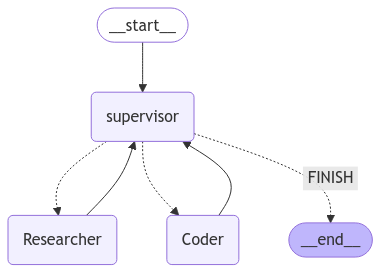

In [9]:
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png(
                output_file_path="./supervisor.png"
            )
        )
    )
except Exception:
    pass

In [10]:
for s in graph.stream(
    {
        "messages":[
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='Here\'s a simple Python code to print "Hello, World!" to the terminal:\n\n```python\nprint(\'Hello, World!\')\n```\n\nWhen you run this code, it will output:\n\n```\nHello, World!\n```', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [11]:
for s in graph.stream(
    {"messages":[HumanMessage(content="Write a brief research report on BTS")]},
    {"recursion_limit":10}
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='**Research Report on BTS in 2023**\n\nBTS, the globally renowned South Korean boy band, continued to capture significant attention in 2023, despite being on a hiatus for mandatory South Korean military service. The seven-member group celebrated their 10th anniversary this year, a testament to their enduring popularity and influence in the music industry.\n\n### Key Developments in 2023:\n\n1. **10th Anniversary Celebrations:**\n   BTS celebrated their 10th anniversary with the "BTS Festa 2023," a large-scale festival held across Seoul in collaboration with the Seoul Metropolitan Government. This event demonstrated BTS\'s sustained popularity and cultural impact, despite the members\' ongoing hiatus.\n\n2. **Military Service:**\n   As of 2023, members of BTS are fulfilling their mandatory military service, a requirement for South Korean men. This significant development had initially saddened 

In [12]:
for s in graph.stream(
    {"messages":[HumanMessage(content="그룹 세븐틴에 대한 간략한 리포트를 한글로 작성해주세요.")]},
    {"recursion_limit":10}
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="세븐틴(SEVENTEEN)은 플레디스 엔터테인먼트 소속의 13인조 남자 그룹으로, 2015년 5월 26일에 미니 앨범 '17 Carat'으로 데뷔했습니다. 이들은 해외에서도 큰 인기를 얻고 있는 다국적 그룹입니다.\n\n세븐틴은 보컬, 힙합, 퍼포먼스 세 개의 유닛으로 구성되어 있습니다. 보컬 팀에는 정한, 조슈아, 우지, 도겸, 승관이 있으며, 힙합 팀에는 에스쿱스, 원우, 민규, 버논이, 퍼포먼스 팀에는 준, 호시, 디에잇, 디노가 속해 있습니다.\n\n세븐틴은 자주 '자체 제작 아이돌'로 불리며, 멤버들이 직접 음악 제작 및 퍼포먼스 연출에 참여하는 것으로 유명합니다. 현재 세븐틴은 전 세계적인 인기를 자랑하며, 특히 스포티파이와 같은 플랫폼에서 높은 청취 수를 기록하고 있습니다. 이들의 최신 미니 앨범은 일본에서 가장 인기 있는 K팝 앨범 중 하나로 꼽히고 있습니다.", additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
